# Visualizing $G(T,P)$
### Neshyba, 2021

This CGI was a total mess and has to be revised

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pint
from pint import UnitRegistry
ureg = UnitRegistry()
AssignQuantity = ureg.Quantity
import PchemLibrary as PL
from mpl_toolkits.mplot3d import axes3d
from copy import deepcopy as makeacopy

In [2]:
%matplotlib notebook

### Lay out a T,P state space

In [3]:
# Lay out the state space
# Tgrid, Pgrid_bar = PL.Statespace([273,400,100],[1,10,101])
Tgrid, Pgrid = PL.Statespace([273,400,100],[1000,200000,101])
Pgrid = AssignQuantity(Pgrid,'pascal')
Tgrid = AssignQuantity(Tgrid,'K')

### Some general-purpose constants

In [4]:
# Gas constant in SI units
R = AssignQuantity(8.314,'J /mol/K')

# Standard state conditions, in SI units
T0 = AssignQuantity(298,'K')
P0 = AssignQuantity(1e5,'pascal')

### Constants pertaining to water
The following cell provides constants for three phases of water - See https://webbook.nist.gov/chemistry/name-ser/ for standard-state entropy values.

In [5]:
# Some SI units related to entropy
EUnits = 'J/K/mol'
dSdTUnits = 'J / kelvin^2 /mole'
dSdPUnits = 'meter ** 3 / kelvin / mole'

# Molar mass of water
M = AssignQuantity(0.018,'kg/mol')

# Parameters for gaseous water
Vgrid_gas = R*Tgrid/Pgrid
CP_gas = AssignQuantity(33.6,EUnits)
SS_gas = [T0,P0,AssignQuantity(188.835,EUnits)] # Specifying the standard state entropy

# Parameters for liquid water
Vgrid_liq = AssignQuantity(18e-6,'m^3 /mol')*np.ones(np.shape(Pgrid)) # Molar volume, as a state-space grid
alpha_P_liq = AssignQuantity(2.1e-4,'1/K') # Thermal expansivity
CP_liq = AssignQuantity(75.4,EUnits) # Heat capacity
SS_liq = [T0,P0,AssignQuantity(69.95,EUnits)]

# Parameters for ice water
Vgrid_sol = 1.1*Vgrid_liq # 10% of icebergs are above the water
alpha_P_sol = alpha_P_liq # Assuming the thermal expansivity of ice is like that of liquid water
CP_sol = AssignQuantity(38,EUnits)
SS_sol = [T0,P0,AssignQuantity(46.5,EUnits)]

### Calculating $\big (\partial S/ \partial T \big )_P$
Below, we calculate $\big (\partial S/ \partial T \big )_P = \frac {C_{P,gas}}T$ (and similar for liquid).

In [6]:
# dSdT
dSdT_gas = CP_gas/Tgrid
dSdT_liq = CP_liq/Tgrid

### Calculating $\big (\partial S/ \partial P \big )_T$

- For the gas, we think $\big (\partial S/ \partial P \big )_T = -R/P$ is a good approximation.
- For the liquid, we think $\big (\partial S/ \partial P \big )_T = -V_{liq} \times \alpha_{P,liq}$, where $V_{liq}$ and $\alpha_{P,liq}$ are constants. 

All these quantities, as written, are on a per-mole basis, according to the constants we've set up above.

In [7]:
# dSdP
dSdP_gas = -R/Pgrid
dSdP_liq = -Vgrid_liq*alpha_P_liq

### Getting the entropy surfaces
Below, we use our state-space integrator, called PL.Integrator, to calculate and display the entropy of water, with offset standard-state entropies appropriate to the each (see https://webbook.nist.gov/chemistry/name-ser/).

In [8]:
# Calculate the entropy of the gas, liquid, and solid as thermodynamic surfaces
S_gas = PL.Integrator([Tgrid, Pgrid], dSdT_gas, dSdP_gas, AssignQuantity, Units=EUnits, SState=SS_gas)
S_liq = PL.Integrator([Tgrid, Pgrid], dSdT_liq, dSdP_liq, AssignQuantity, Units=EUnits, SState=SS_liq)

Assigning units: J/K/mol
Assigning units: J/K/mol


/home/instructor/chem340/source/Week_12a.VisualizingG/PchemLibrary.py:84: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  Fgrid[i,:] = integral_along_y
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:591: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


### Calculating $G(T,P)$
We do this below by integrating $dG = -SdT+VdP$

In [9]:
GS_gas = [T0,P0,AssignQuantity(-228600,'J/mol')]
G_gas = PL.Integrator([Tgrid, Pgrid], -S_gas, Vgrid_gas, AssignQuantity, Units='J/mol', SState=GS_gas)

GS_liq = [T0,P0,AssignQuantity(-237100,'J/mol')]
G_liq = PL.Integrator([Tgrid, Pgrid], -S_liq, Vgrid_liq, AssignQuantity, Units='J/mol', SState=GS_liq)

Assigning units: J/mol
Assigning units: J/mol


<IPython.core.display.Javascript object>


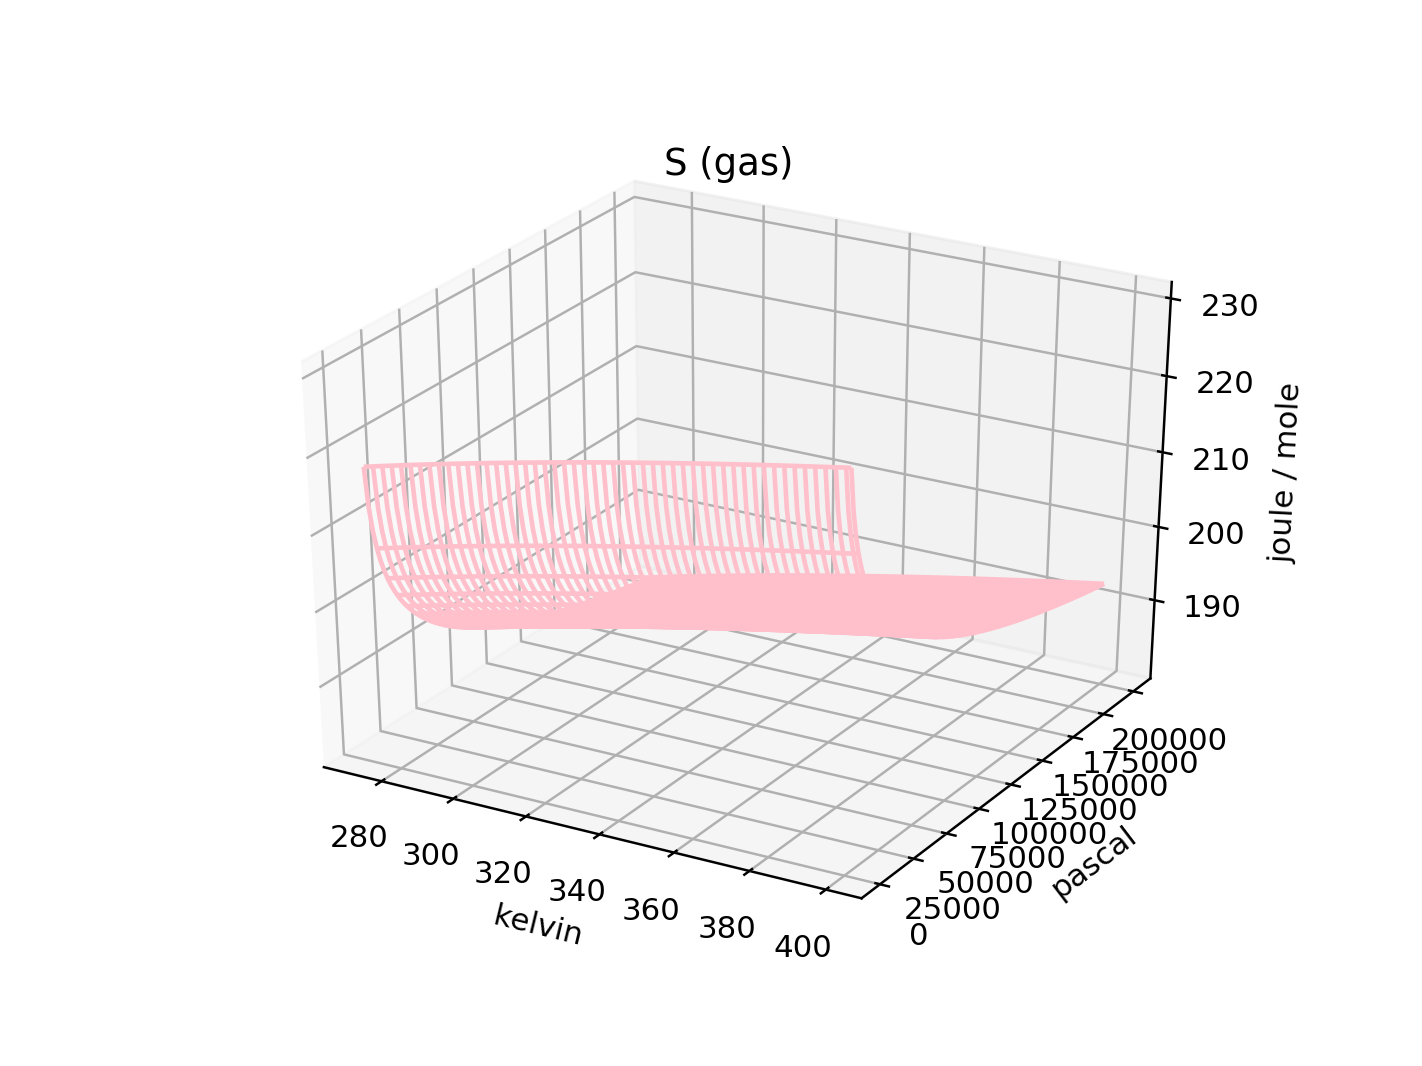

/usr/local/lib/python3.6/dist-packages/numpy/lib/stride_tricks.py:257: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


<IPython.core.display.Javascript object>


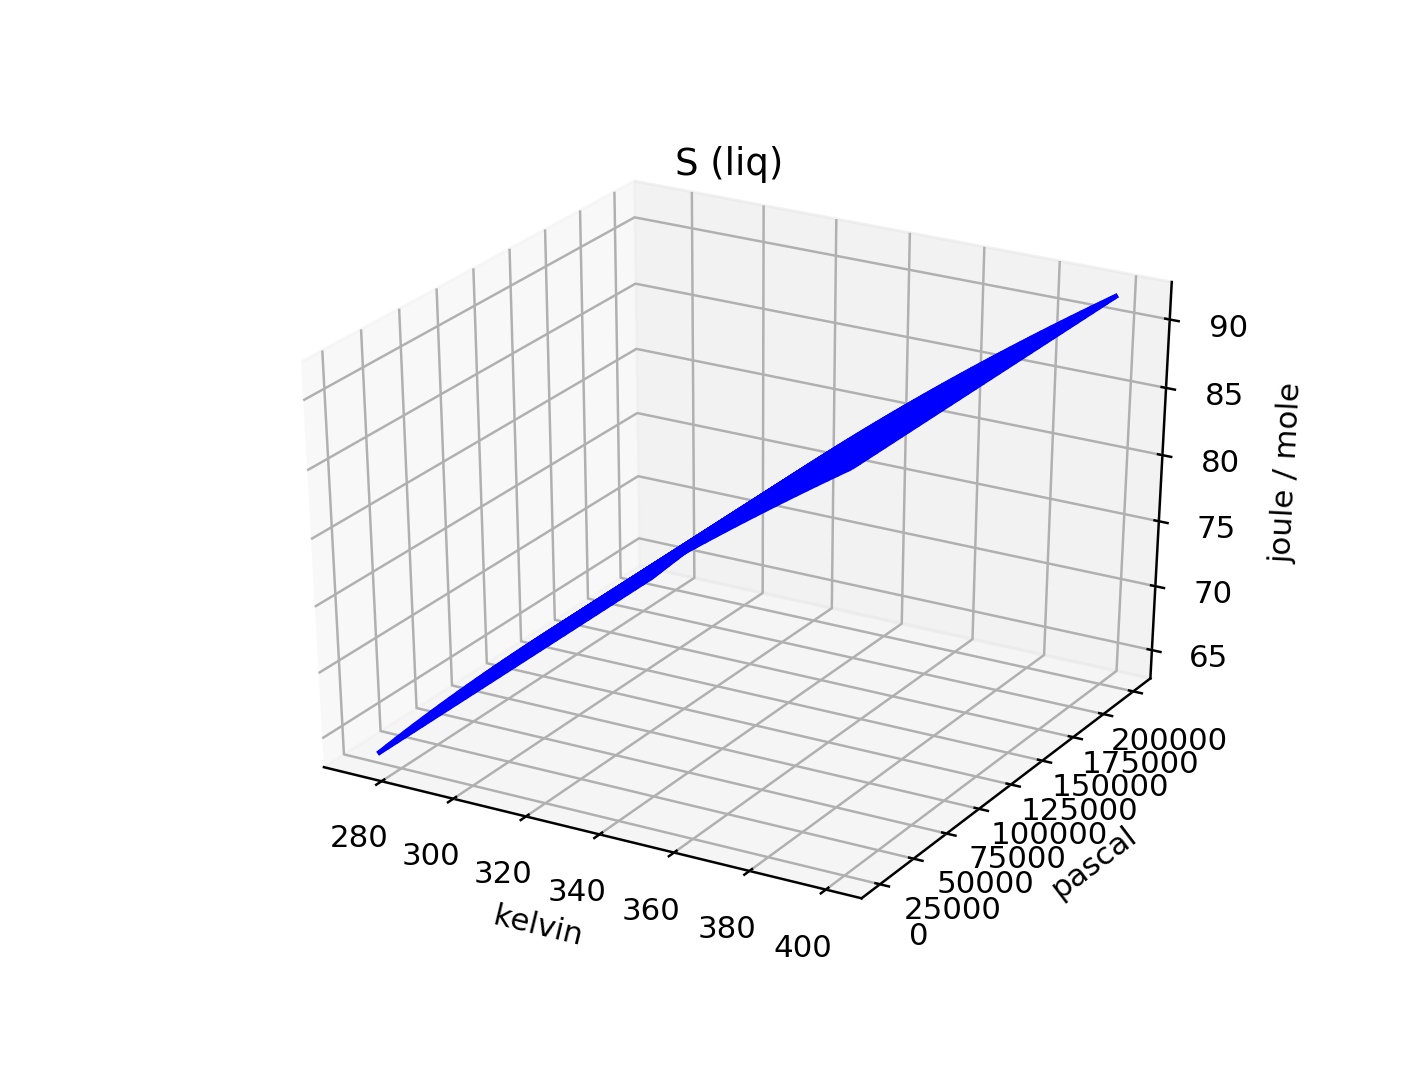

<IPython.core.display.Javascript object>


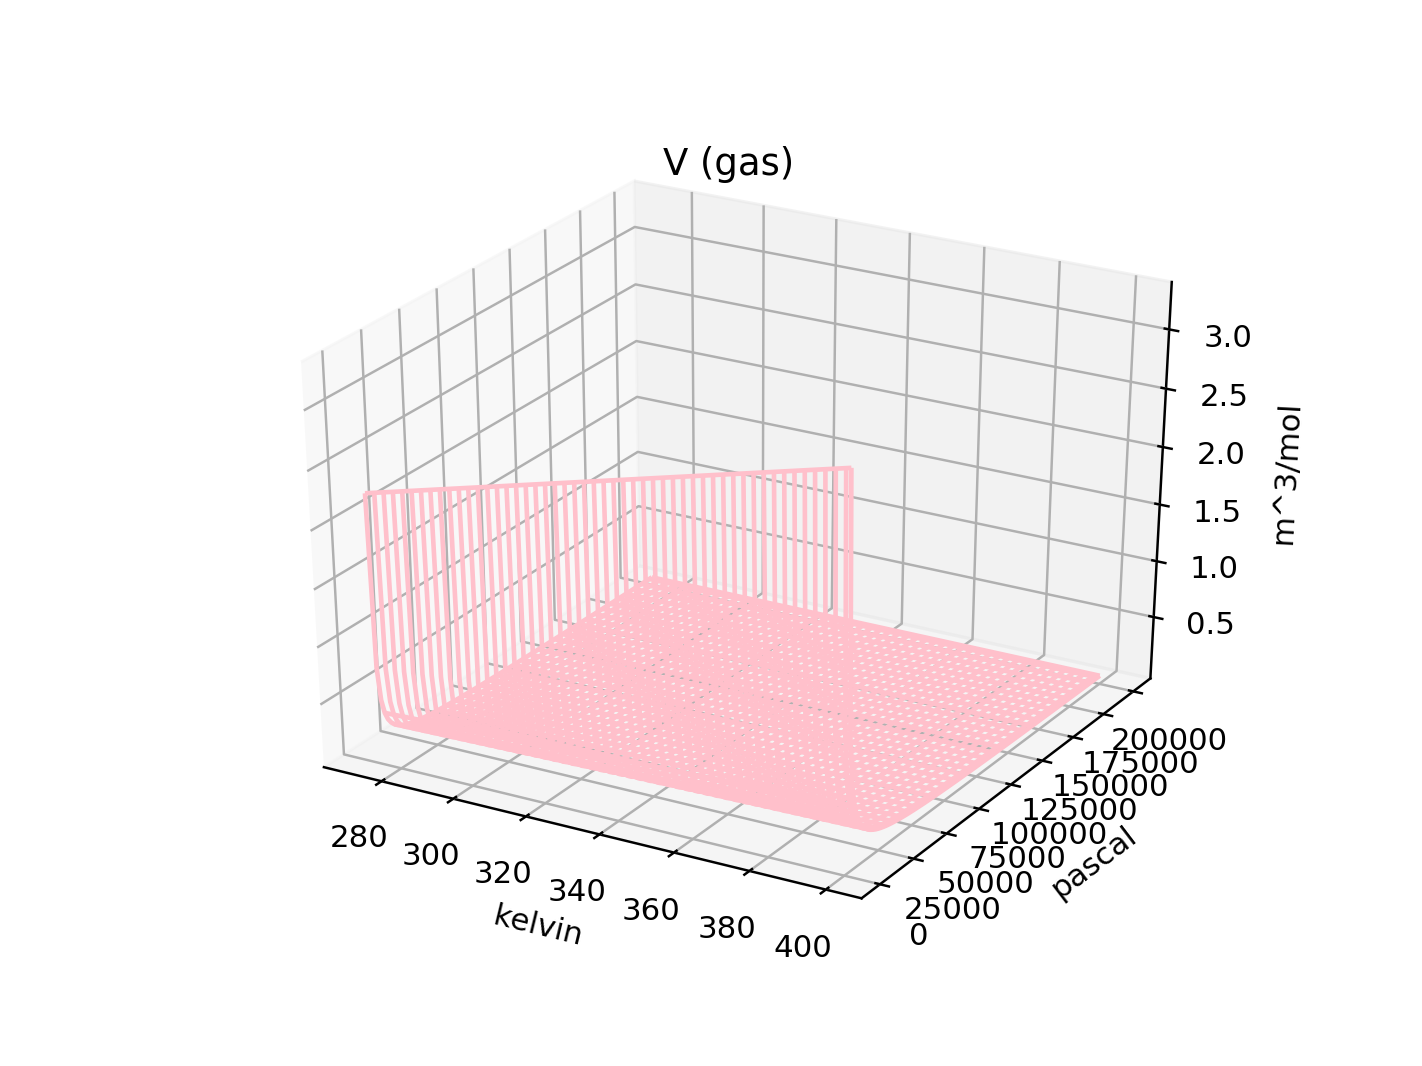

<IPython.core.display.Javascript object>


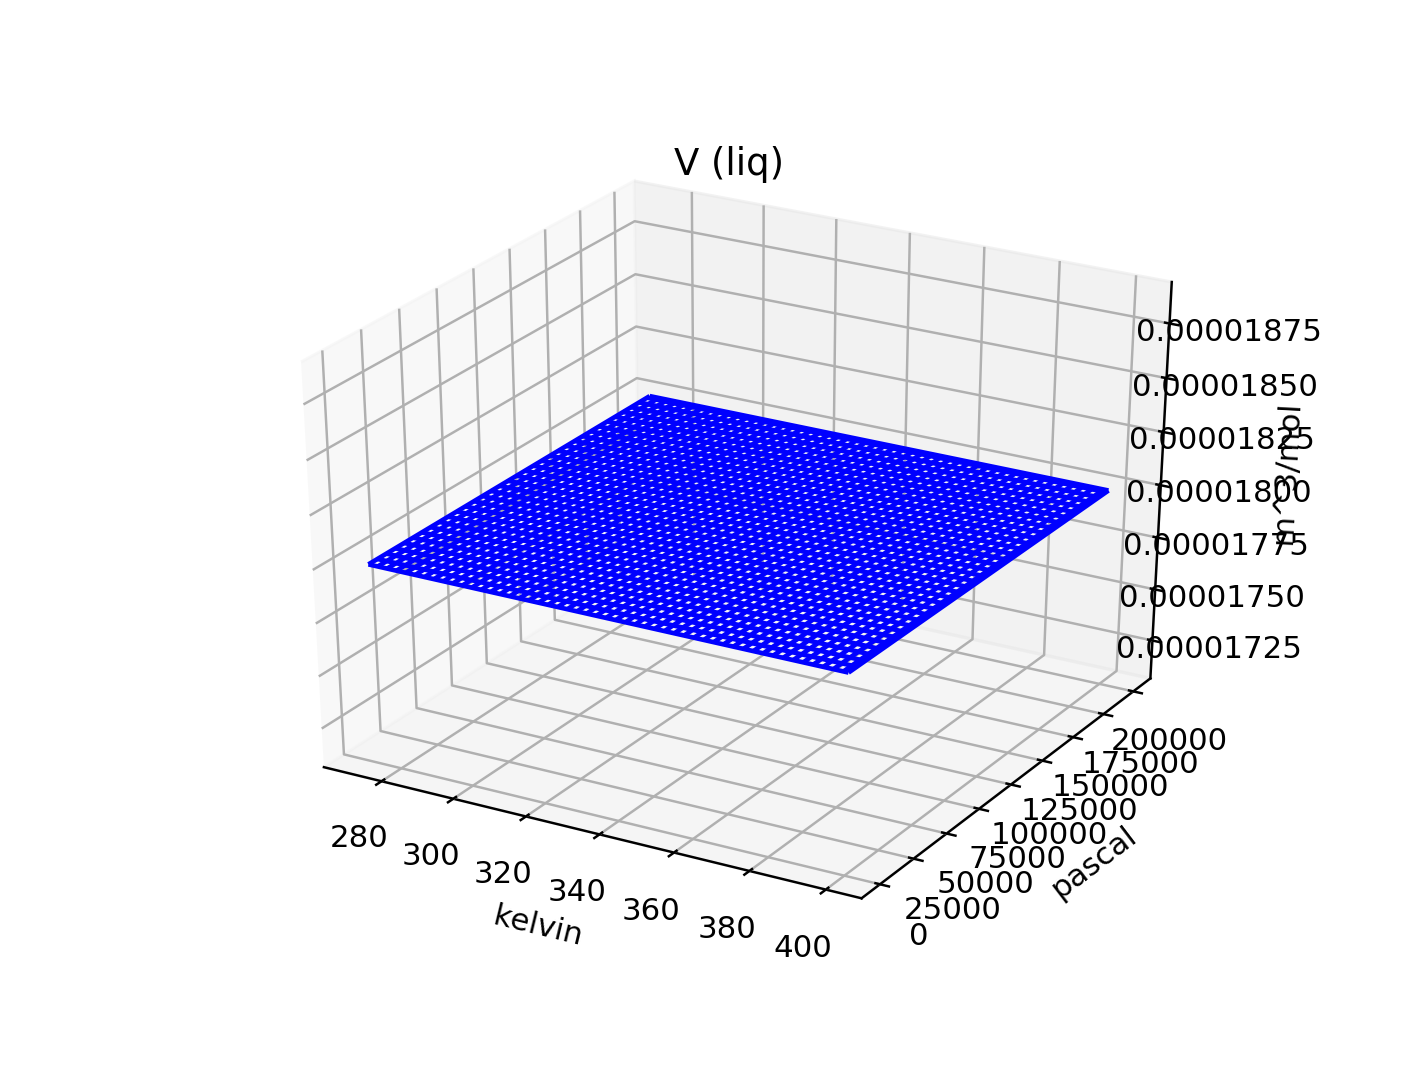

Text(0.5, 0.92, 'V (liq)')

In [10]:
# Plot the gas' S
ax = plt.figure().gca(projection='3d') # Set up a three dimensional graphics window 
ax.plot_wireframe(Tgrid, Pgrid, S_gas, color='pink')
ax.set_xlabel(str(Tgrid.units))
ax.set_ylabel(str(Pgrid.units))
ax.set_zlabel(str(G_gas.units))
ax.set_title('S (gas)')

 # Plot the liquid's S
ax = plt.figure().gca(projection='3d') # Set up a three dimensional graphics window 
ax.plot_wireframe(Tgrid, Pgrid, S_liq, color='blue')
ax.set_xlabel(str(Tgrid.units))
ax.set_ylabel(str(Pgrid.units))
ax.set_zlabel(str(G_liq.units))
ax.set_title('S (liq)')

# Plot the gas' V
ax = plt.figure().gca(projection='3d') # Set up a three dimensional graphics window 
ax.plot_wireframe(Tgrid, Pgrid, Vgrid_gas, color='pink')
ax.set_xlabel(str(Tgrid.units))
ax.set_ylabel(str(Pgrid.units))
ax.set_zlabel(str('m^3/mol'))
ax.set_title('V (gas)')

 # Plot the liquid's V
ax = plt.figure().gca(projection='3d') # Set up a three dimensional graphics window 
ax.plot_wireframe(Tgrid, Pgrid, Vgrid_liq, color='blue')
ax.set_xlabel(str(Tgrid.units))
ax.set_ylabel(str(Pgrid.units))
ax.set_zlabel(str('m^3/mol'))
ax.set_title('V (liq)')


### Visualizing $G(T,P)$

<IPython.core.display.Javascript object>


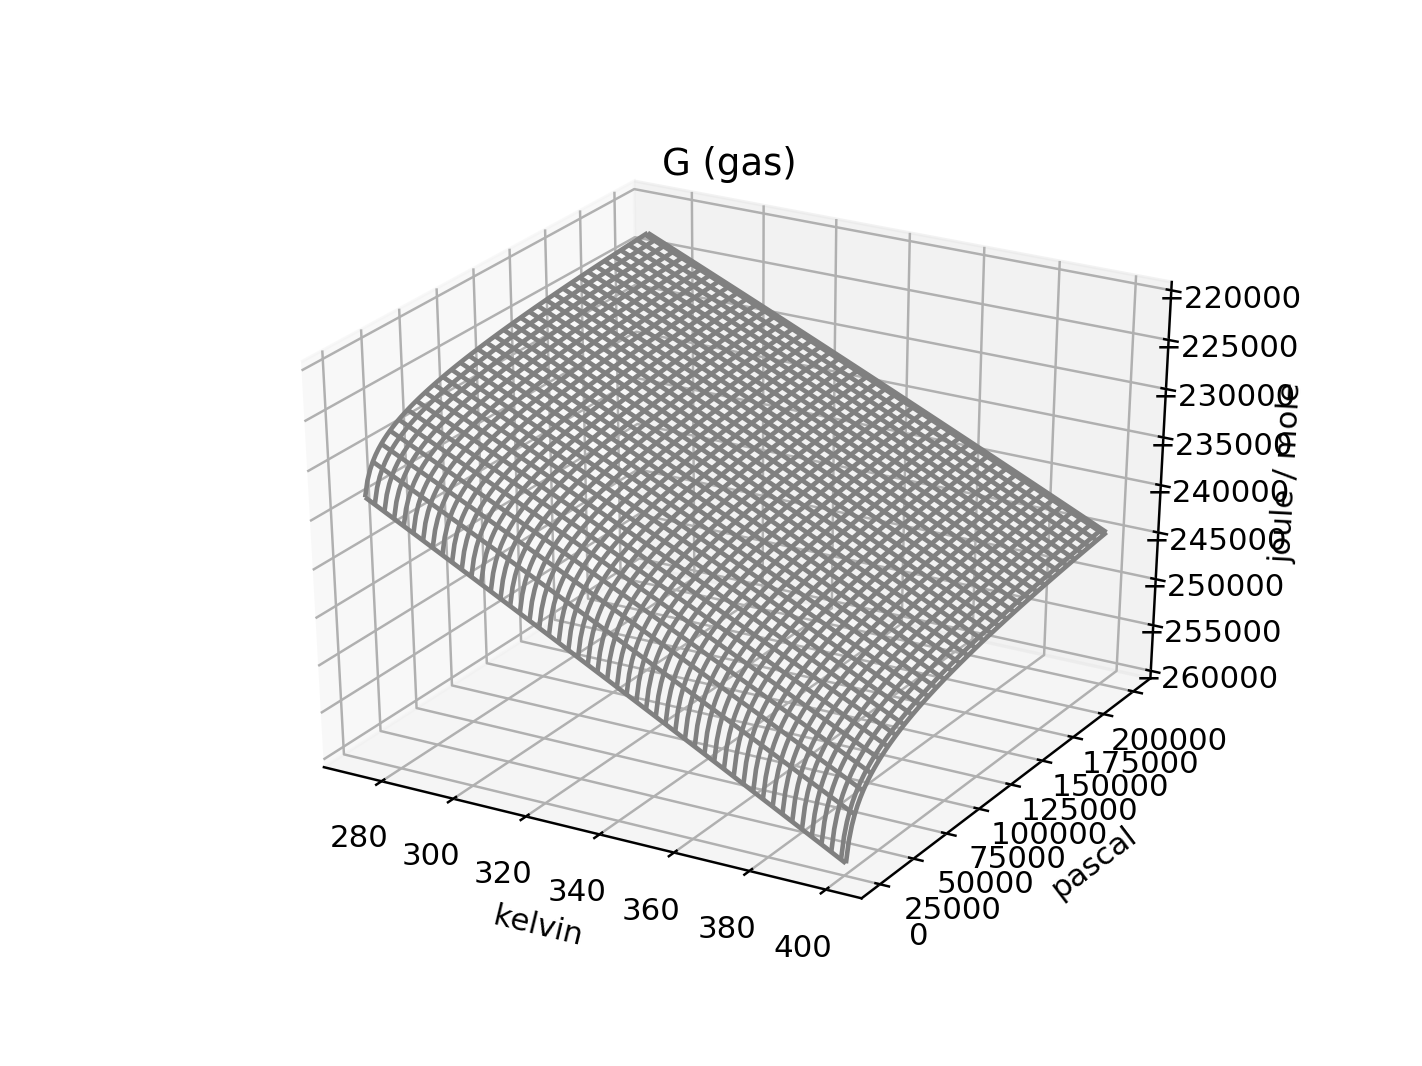

<IPython.core.display.Javascript object>


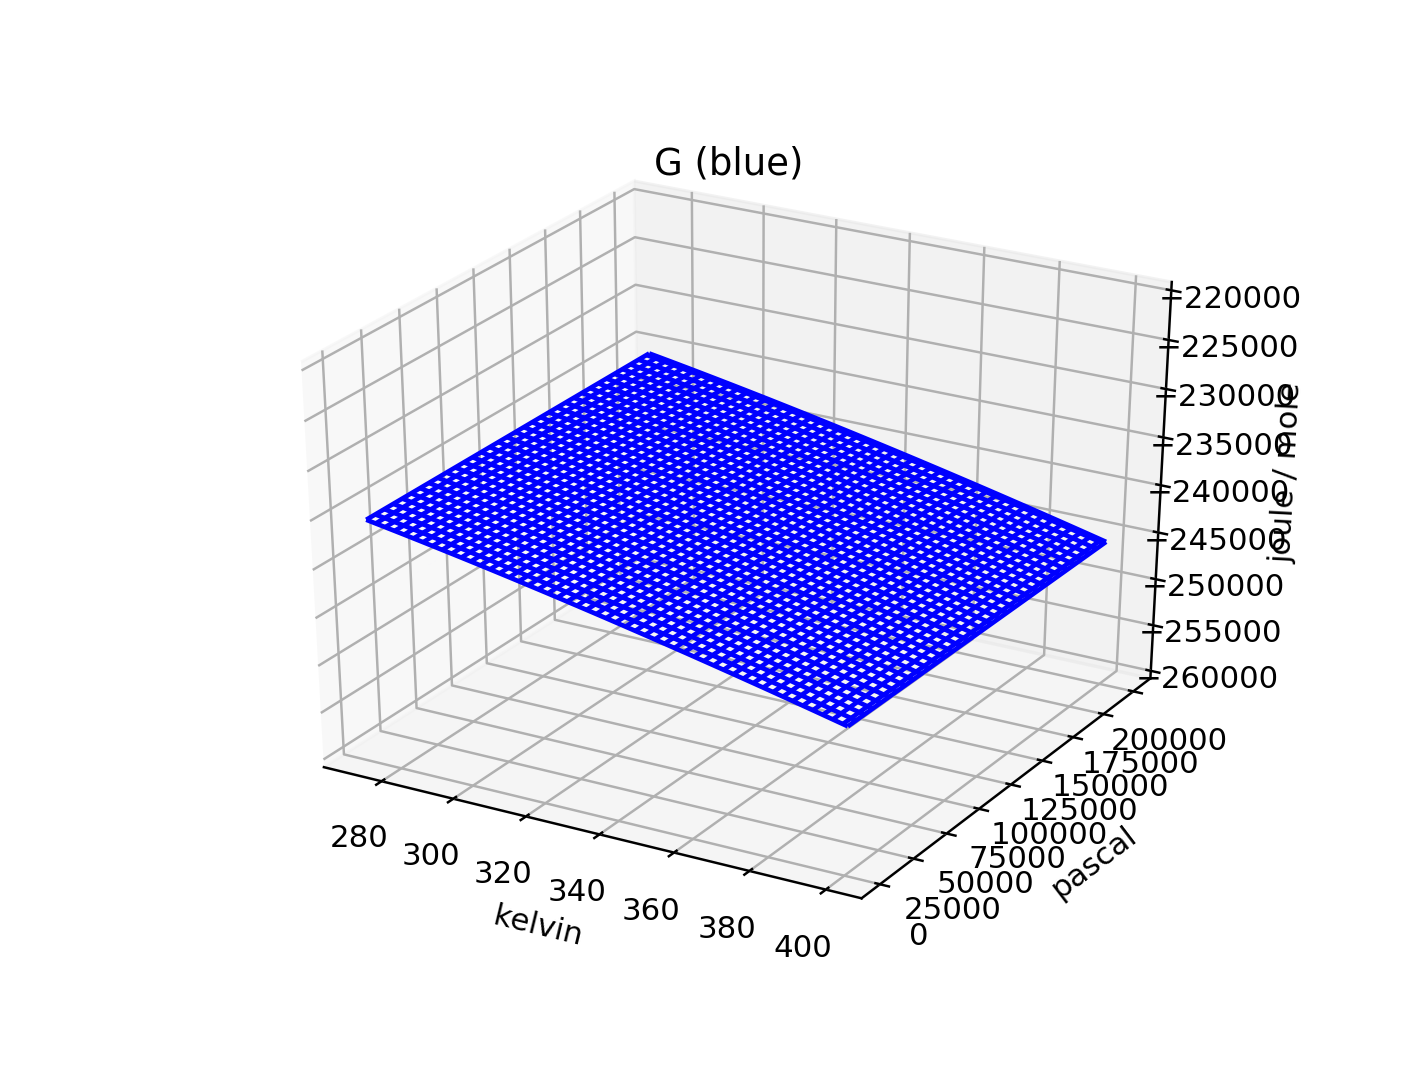

<IPython.core.display.Javascript object>


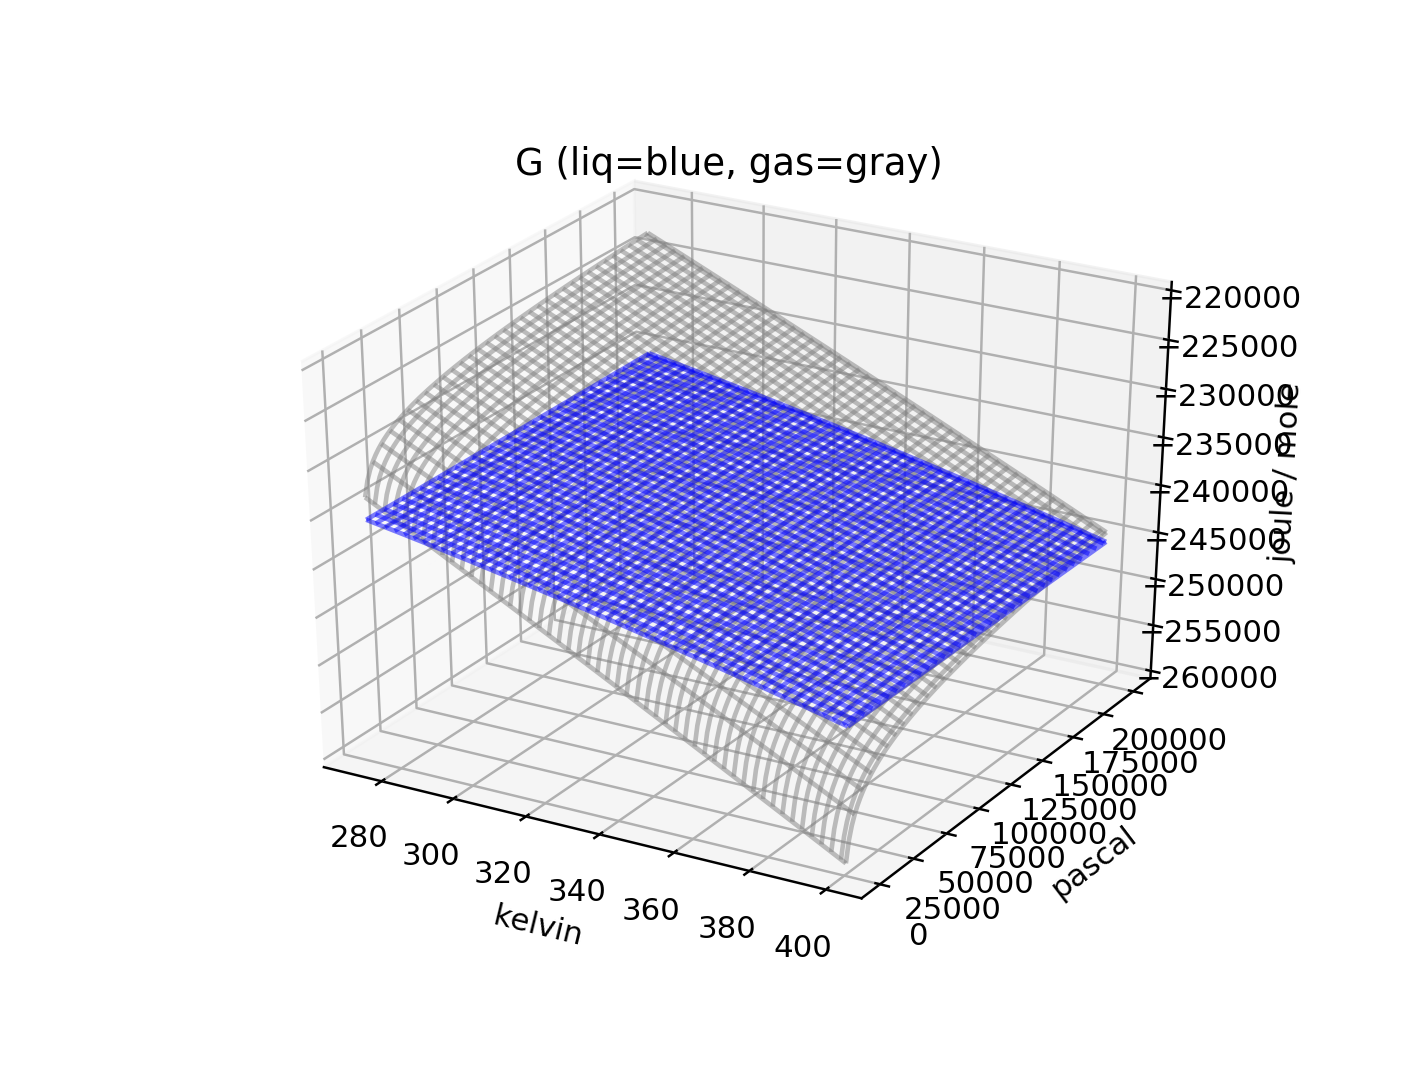

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:637: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(a)


<IPython.core.display.Javascript object>


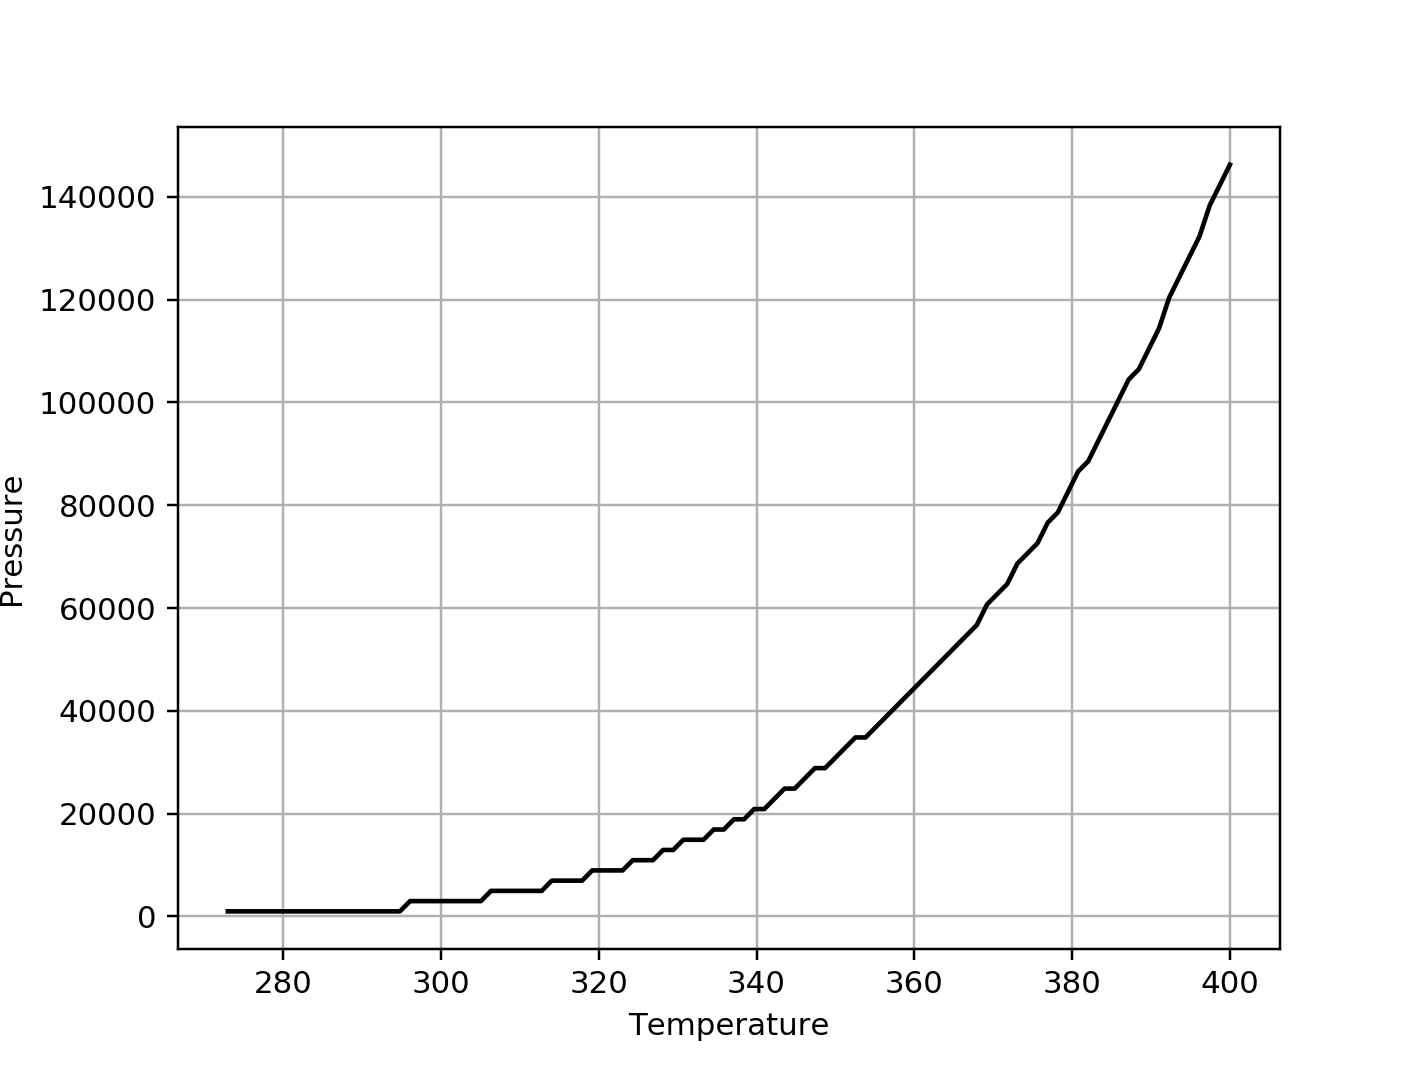

In [11]:
# Plot the gas' G
myalpha = 0.5
myzlim = [-260000, -220000]
ax = plt.figure().gca(projection='3d') # Set up a three dimensional graphics window 
ax.plot_wireframe(Tgrid, Pgrid, G_gas, color='gray')
ax.set_xlabel(str(Tgrid.units))
ax.set_ylabel(str(Pgrid.units))
ax.set_zlabel(str(G_gas.units))
ax.set_zlim(myzlim)
ax.set_title('G (gas)')

 # Plot the liquid's G
ax = plt.figure().gca(projection='3d') # Set up a three dimensional graphics window 
ax.plot_wireframe(Tgrid, Pgrid, G_liq, color='blue')
ax.set_xlabel(str(Tgrid.units))
ax.set_ylabel(str(Pgrid.units))
ax.set_zlabel(str(G_liq.units))
ax.set_zlim(myzlim)
ax.set_title('G (blue)')

# Plot them together
ax = plt.figure().gca(projection='3d') # Set up a three dimensional graphics window 
ax.plot_wireframe(Tgrid, Pgrid, G_gas, color='gray',alpha=myalpha)
ax.plot_wireframe(Tgrid, Pgrid, G_liq, color='blue',alpha=myalpha)
ax.set_xlabel(str(Tgrid.units))
ax.set_ylabel(str(Pgrid.units))
ax.set_zlabel(str(G_liq.units))
ax.set_zlim(myzlim)
ax.set_title('G (liq=blue, gas=gray)')

# This gets the locus of points
G_diff2 = (G_gas-G_liq)**2
Temperatures = Tgrid[:,0]
iPlist = []
for i in range(len(Temperatures)):
    iP = np.argmin(G_diff2[i,:])
    iPlist.append(iP)
Pressures = []
Gvals = []
for i in range(len(Temperatures)):
    j = iPlist[i]
    Pressures = np.append(Pressures,Pgrid[0,j])
    Gvals = np.append(Gvals,G_gas[i,j])
ax = plt.figure().gca(projection='3d') # Set up a three dimensional graphics window 
ax.plot_wireframe(Tgrid, Pgrid, G_gas, color='gray',alpha=myalpha)
ax.plot_wireframe(Tgrid, Pgrid, G_liq, color='blue',alpha=myalpha)
ax.set_xlabel(str(Tgrid.units))
ax.set_ylabel(str(Pgrid.units))
ax.set_zlabel(str(G_liq.units))
ax.set_zlim(myzlim)
ax.set_title('G (liq=blue, gas=gray)')
ax.scatter3D(Temperatures,Pressures,Gvals,color='black')

# This makes a 2d plot    
plt.figure()
plt.plot(Temperatures,Pressures,color='black')
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.grid(True)

<IPython.core.display.Javascript object>


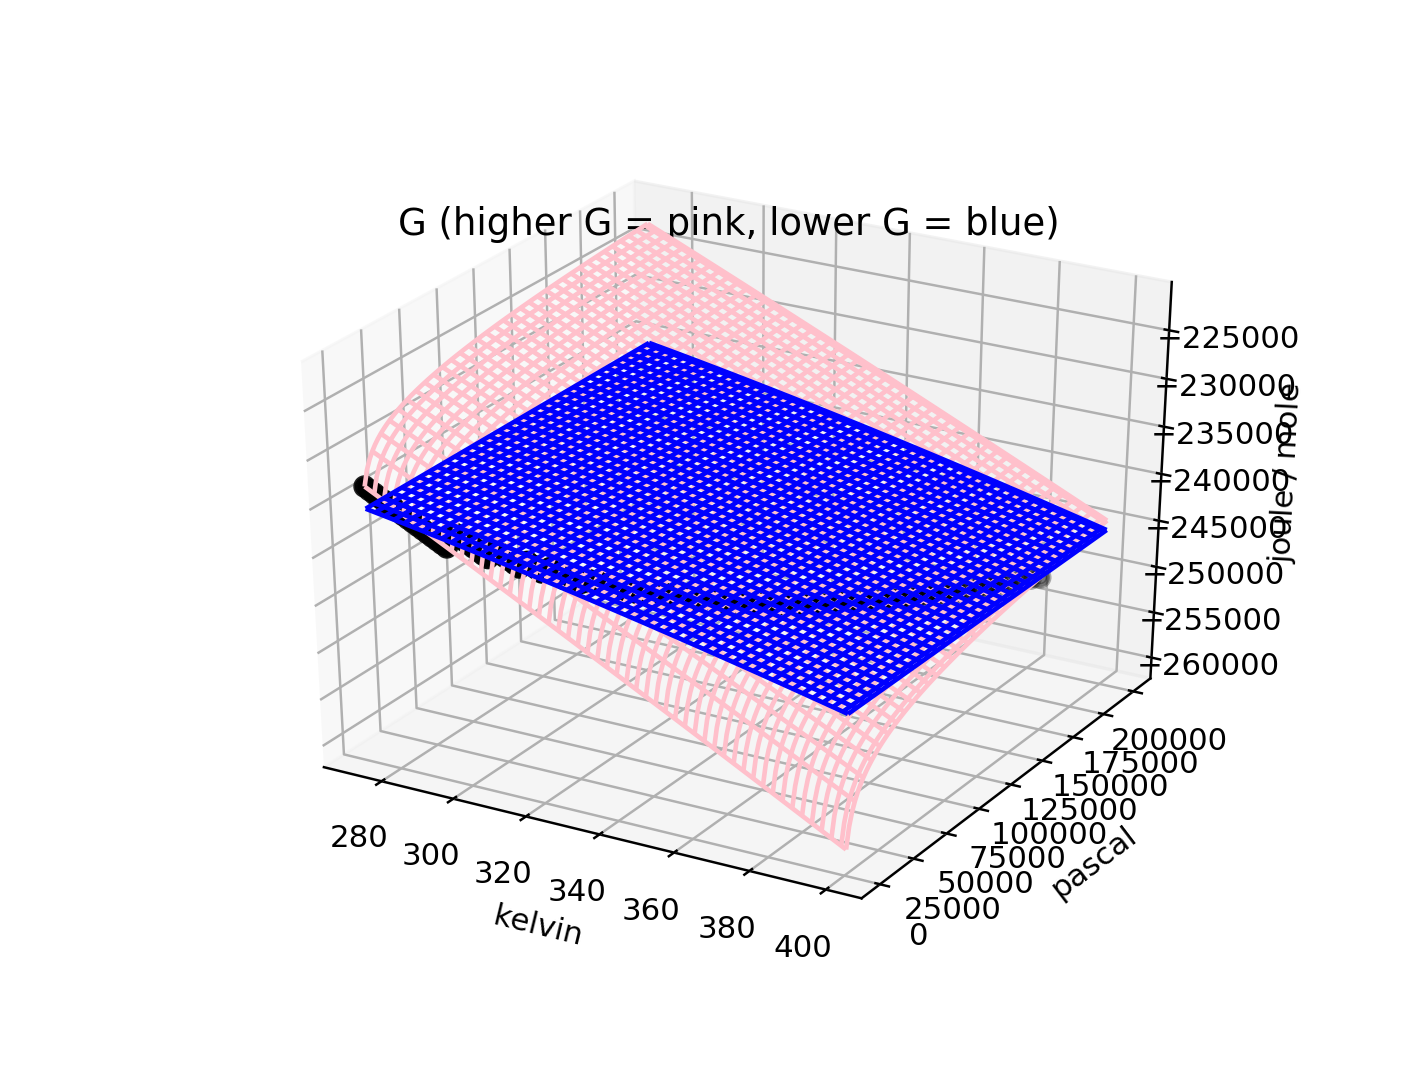

Text(0.5, 0.8464, 'G (higher G = pink, lower G = blue)')

In [12]:
ax = plt.figure().gca(projection='3d') # Set up a three dimensional graphics window 
ax.plot_wireframe(Tgrid, Pgrid, G_gas, color='pink')
ax.plot_wireframe(Tgrid, Pgrid, G_liq, color='blue')
ax.scatter3D(Temperatures,Pressures,Gvals,color='black')
ax.set_xlabel(str(Tgrid.units))
ax.set_ylabel(str(Pgrid.units))
ax.set_zlabel(str(G_liq.units))
ax.set_title('G (liq=blue, gas=pink)')

# This gets the locus of points
nT, nP = np.shape(G_liq)
G_top = makeacopy(G_gas)
G_bot = makeacopy(G_liq)
for iT in range(nT):
    for iP in range(nP):
        if(G_liq[iT,iP]>G_gas[iT,iP]): 
            G_top[iT,iP]=G_liq[iT,iP]
            G_bot[iT,iP]=G_gas[iT,iP]
ax.scatter3D(Temperatures,Pressures,Gvals,color='black',s=40)

ax.set_xlabel(str(Tgrid.units))
ax.set_ylabel(str(Pgrid.units))
ax.set_zlabel(str(G_liq.units))
ax.set_title('G (higher G = pink, lower G = blue)')

### Pause for analysis
On paper, on a pressure/temperature graph, sketch the locus of points at which the Gibbs energy of the gas equals that of the liquid. What you see should look a lot like the Clausius-Clapeyron equation results for gas/liquid equilibria. It should look something like the graph below.

100


<IPython.core.display.Javascript object>


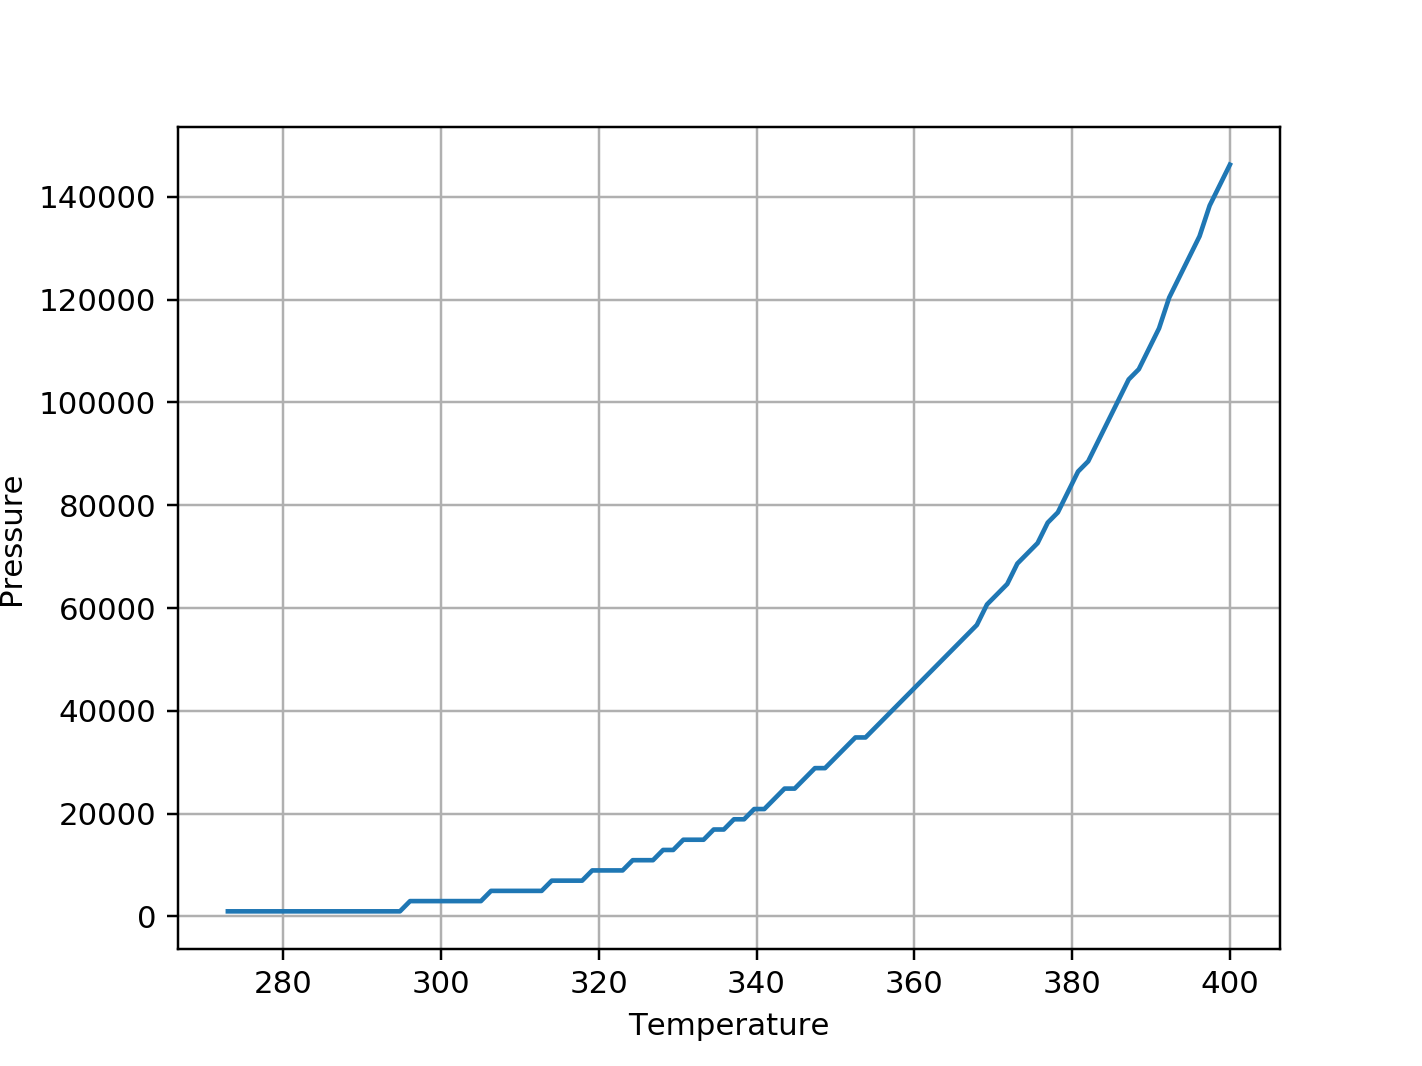

In [13]:
G_diff2 = (G_gas-G_liq)**2
Temperatures = Tgrid[:,0]
iPlist = []
for i in range(len(Temperatures)):
    iP = np.argmin(G_diff2[i,:])
    iPlist.append(iP)
# # iP,iT = np.where(G_diff2 == np.amin(G_diff2,axis=0))
# iPlist = list(iP)
Pressures = []
Gvals = []
print(len(iPlist))
for i in range(len(Temperatures)):
    j = iPlist[i]
    Pressures = np.append(Pressures,Pgrid[0,j])
    Gvals = np.append(Gvals,G_gas[i,j])
plt.figure()
plt.plot(Temperatures,Pressures)
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.grid(True)

### Application
Look up then enthalpy and entropy changes for the reaction $C(s)+O_2(g) -> CO_2(g)$, and use them to calculate the change in Gibbs energy (unmixed). 

Then use the entropy of dilution to find the entropy change when one mole of $CO_2(g)$ is diluted from its volume at standard atmosphere temperature and pressure (which you can get from PV=nRT), to a volume of 4.2 x 10^18 m^3 (which is the effective volume of Earth's atmosphere). How do the numbers stack up?

<IPython.core.display.Javascript object>


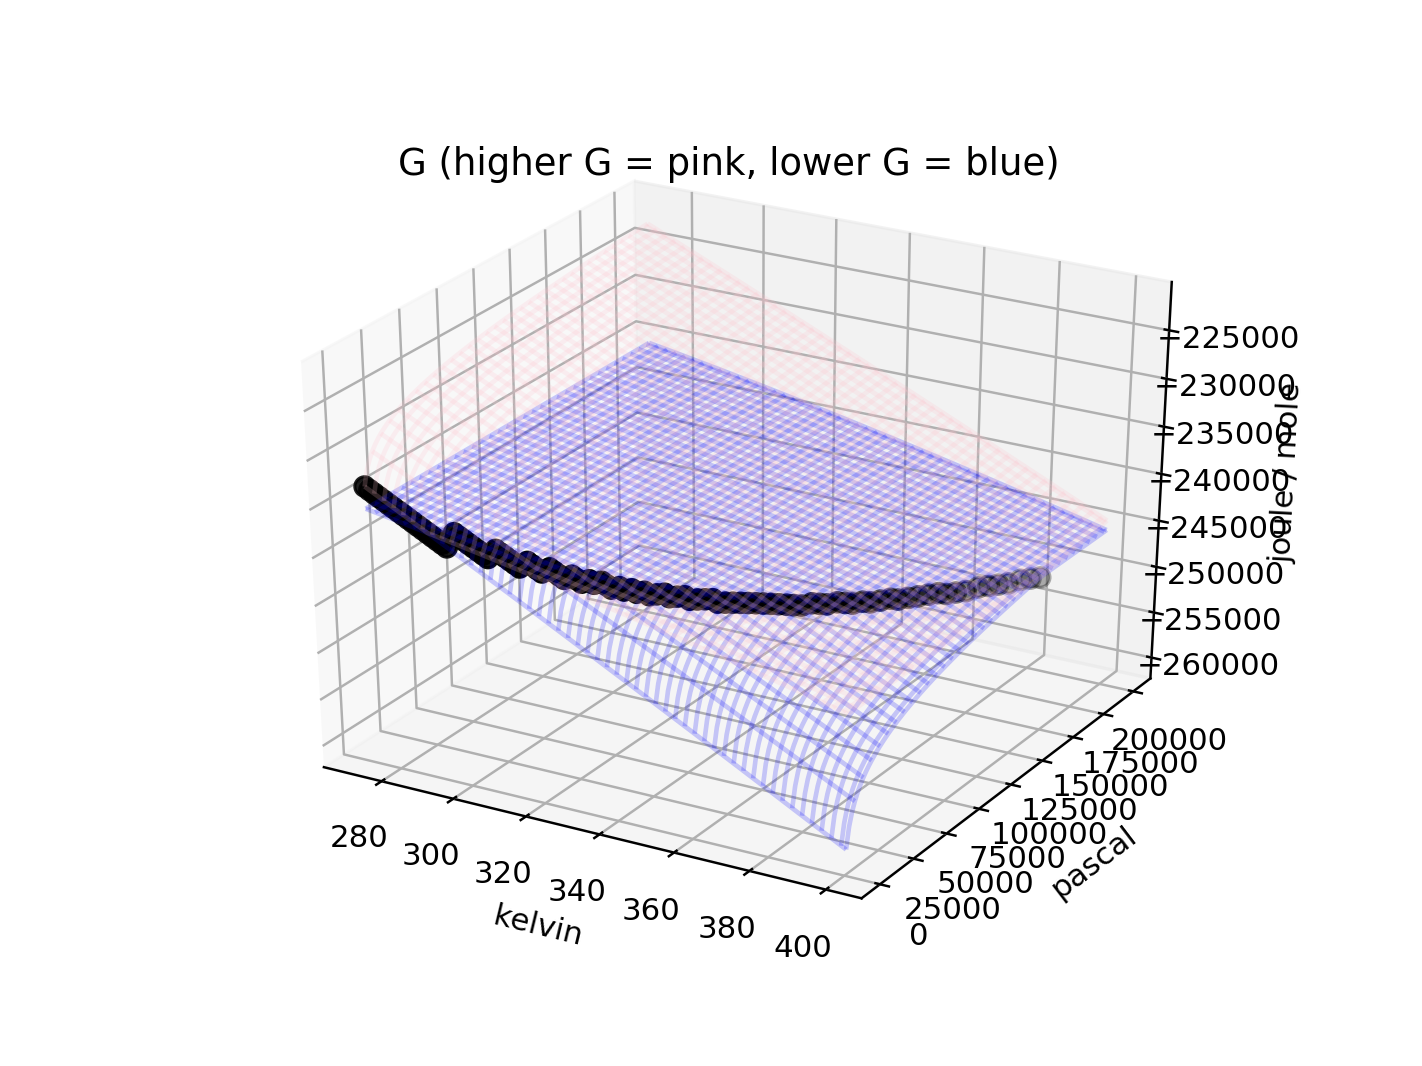

Text(0.5, 0.92, 'G (higher G = pink, lower G = blue)')

In [14]:
myalpha = .2
ax = plt.figure().gca(projection='3d') # Set up a three dimensional graphics window 
ax.plot_wireframe(Tgrid, Pgrid, G_top, color='pink',alpha=myalpha)
ax.plot_wireframe(Tgrid, Pgrid, G_bot, color='blue',alpha=myalpha)
ax.scatter3D(Temperatures,Pressures,Gvals,color='black',s=40)
ax.set_xlabel(str(Tgrid.units))
ax.set_ylabel(str(Pgrid.units))
ax.set_zlabel(str(G_liq.units))
ax.set_title('G (higher G = pink, lower G = blue)')